In [1]:
import os
import sys
import time
import h5py
import pygrib
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp2d
from datetime import datetime, timedelta

sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return 2*(x/100 - 0.5)

def norm_t(x):
    return (x-282.8)/16.2/2

def norm_u(x):
    return (x-0.74)/7.8/2

def norm_pwat(x):
    return (x-20.5)/16.3/2

def norm_cape(x):
    return (x-101.4)/328/2

In [4]:
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_GFS/'

**Batch gen 2021**

In [5]:
size_mrms = 128
size_half = 64
gap = 64 # samples will have at least 5 non-overlap grids on height and width dimensions 
thres_dry = 1.0 # 1.0 mm = rain on that grid
thres_rain_cover = 0.33 # at least 25% of the grids should have rain
thres_land_cover = 0.90 # at least 90% of the grids should stay within land
thres_extreme = 30 # if a grid has 20 mm/hr or above, the sample will bypass "thres_rain_cover"
thres_extreme_cover = 0.05 # if a grid has 20 mm/hr or above, the sample will bypass "thres_rain_cover"

In [6]:
with h5py.File(save_dir+'MRMS_ERA5_domain.hdf', 'r') as h5io:
    lon_ERA5 = h5io['lon_ERA5'][...]
    lat_ERA5 = h5io['lat_ERA5'][...]
    lon_MRMS = h5io['lon_MRMS'][...]
    lat_MRMS = h5io['lat_MRMS'][...]
    land_mask_MRMS = h5io['land_mask_MRMS'][...]
    elev_MRMS = h5io['elev_MRMS'][...]
    indx = h5io['MRMS_to_ERA5_indx'][...]
    indy = h5io['MRMS_to_ERA5_indy'][...]

elev_MRMS[elev_MRMS<0] = 0
elev_MRMS = elev_MRMS/2000 - 1

In [7]:
with h5py.File(save_dir+'MRMS_RQI_example.hdf', 'r') as h5io:
    RQI = h5io['RQI'][...]

**generating batches**

In [8]:
x_mrms = 3500
y_mrms = 7000
N_grids = size_mrms*size_mrms
batch_file_name = 'GFS_y{:04d}_lead{:02d}_dt{:04d}_i{:04d}_j{:04d}.npy'

In [9]:
x_GFS = 361
y_GFS = 721

x_lr6 = np.linspace(0, 1, 6)
x_lr7 = np.linspace(0, 1, 7)
x_hr = x_hr128 = np.linspace(0, 1, 128)

data = np.empty((1, size_mrms, size_mrms, 9))
# 0MRMS HR precip
# 1MRMS LR precip
# 2ERA5 Precip
# 3CAPE
# 4PWAT
# 5RH
# 6U
# 7T
# 8elev

In [10]:
year = 2021
base = datetime(year, 1, 1)
date_list = [base + timedelta(days=h) for h in range(365)]
LEADs = [3, 6, 9, 12, 15, 18, 21, 24]

In [11]:
lead = LEADs[0]
i_dt = 0
dt = date_list[0]
    
filename_gfs = datetime.strftime(dt, 
'/glade/campaign/collections/rda/data/ds084.1/%Y/%Y%m%d/gfs.0p25.%Y%m%d%H.f{:03d}.grib2'.format(lead))

dt0 = dt + timedelta(hours=lead-2)
dt1 = dt + timedelta(hours=lead-1)
dt2 = dt + timedelta(hours=lead)

dt_str0 = datetime.strftime(dt0, '%Y%m%d-%H%M%S')
dt_str1 = datetime.strftime(dt1, '%Y%m%d-%H%M%S')
dt_str2 = datetime.strftime(dt2, '%Y%m%d-%H%M%S')

name0 = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str0)
name1 = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str1)
name2 = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str2)

filename0 = MRMS_dir + name0
filename1 = MRMS_dir + name1
filename2 = MRMS_dir + name2

flag_mrms0 = os.path.isfile(filename0)
flag_mrms1 = os.path.isfile(filename1)
flag_mrms2 = os.path.isfile(filename2)
flag_gfs = os.path.isfile(filename_gfs)


In [12]:
with pygrib.open(filename0) as grbio:
    MRMS = grbio[1].values
    
with pygrib.open(filename0) as grbio:
    MRMS += grbio[1].values
    
with pygrib.open(filename0) as grbio:
    MRMS += grbio[1].values
    
# flip --> lower latitude at the bottom
MRMS = np.flipud(MRMS)

In [13]:
with pygrib.open(filename_gfs) as grbio:
    T = grbio[314+1].values #
    U = grbio[319+1].values
    RH = grbio[315+1].values
    APCP = grbio[450+1].values
    CAPE = grbio[473+1].values
    PWAT = grbio[475+1].values

T_NA = T[:-360, 720:]
T_NA = np.flipud(np.concatenate((T_NA, T[:-360, 0][:, None]), axis=1))

U_NA = U[:-360, 720:]
U_NA = np.flipud(np.concatenate((U_NA, U[:-360, 0][:, None]), axis=1))

RH_NA = RH[:-360, 720:]
RH_NA = np.flipud(np.concatenate((RH_NA, RH[:-360, 0][:, None]), axis=1))

APCP_NA = APCP[:-360, 720:]
APCP_NA = np.flipud(np.concatenate((APCP_NA, APCP[:-360, 0][:, None]), axis=1))

CAPE_NA = CAPE[:-360, 720:]
CAPE_NA = np.flipud(np.concatenate((CAPE_NA, CAPE[:-360, 0][:, None]), axis=1))

PWAT_NA = PWAT[:-360, 720:]
PWAT_NA = np.flipud(np.concatenate((PWAT_NA, PWAT[:-360, 0][:, None]), axis=1))

In [ ]:
for i_mrms in range(0, x_mrms-size_mrms+gap, gap):
    for j_mrms in range(0, y_mrms-size_mrms+gap, gap):
        
        i0 = i_mrms; i1 = i0 + size_mrms
        j0 = j_mrms; j1 = j0 + size_mrms

        if (np.sum(RQI[i0:i1, j0:j1]) < 0.75) == 0:
        
            patch_ = MRMS[i0:i1, j0:j1]
            land_mask_ = land_mask_MRMS[i0:i1, j0:j1]

            r_rain = np.sum(patch_ > thres_dry)/N_grids
            
            flag_size = patch_.shape == (size_mrms, size_mrms)
            flag_rain_cover = r_rain >= thres_rain_cover
            flag_land_cover = (np.sum(land_mask_)/N_grids) >= thres_land_cover
            flag_extreme = np.logical_and(np.max(patch_) >= thres_extreme, r_rain >= thres_extreme_cover)

            flag_pass1 = np.logical_and(flag_rain_cover, flag_land_cover)
            flag_pass2 = np.logical_and(flag_extreme, flag_land_cover)
            flag_pass_final = np.logical_or(flag_pass1, flag_pass2)

            if flag_size and flag_pass_final:
                
                i_era = indx[i0:i1, j0:j1]
                j_era = indy[i0:i1, j0:j1]

                i_min = np.int(np.min(i_era))
                i_max = np.int(np.max(i_era))
                j_min = np.int(np.min(j_era))
                j_max = np.int(np.max(j_era))
                
                data_t = T_NA[i_min:i_max+1, j_min:j_max+1]
                data_u = U_NA[i_min:i_max+1, j_min:j_max+1]
                data_r = RH_NA[i_min:i_max+1, j_min:j_max+1]
                data_pwat = PWAT_NA[i_min:i_max+1, j_min:j_max+1]
                data_cape = CAPE_NA[i_min:i_max+1, j_min:j_max+1]
                data_apcp = APCP_NA[i_min:i_max+1, j_min:j_max+1]
                
                shape_lr = data_t.shape
                if shape_lr[0] == 6:
                    x_ = x_lr6
                else:
                    x_ = x_lr7
                
                if shape_lr[1] == 6:
                    y_ = x_lr6
                else:
                    y_ = x_lr7


                elev_ = elev_MRMS[i0:i1, j0:j1]
                data[0, ..., 8] = elev_
                
                interp_obj_t = interp2d(y_, x_, data_t, kind='linear')
                data[0, ..., 7] = interp_obj_t(x_hr128, x_hr128)

                interp_obj_u = interp2d(y_, x_, data_u, kind='linear')
                data[0, ..., 6] = interp_obj_u(x_hr128, x_hr128)

                interp_obj_r = interp2d(y_, x_, data_r, kind='linear')
                data[0, ..., 5] = interp_obj_r(x_hr128, x_hr128)

                interp_obj_pwat = interp2d(y_, x_, data_pwat, kind='linear')
                data[0, ..., 4] = interp_obj_pwat(x_hr128, x_hr128)

                interp_obj_cape = interp2d(y_, x_, data_cape, kind='linear')
                data[0, ..., 3] = interp_obj_cape(x_hr128, x_hr128)

                interp_obj_apcp = interp2d(y_, x_, data_apcp, kind='linear')
                data[0, ..., 2] = interp_obj_apcp(x_hr128, x_hr128)

                data[0, ..., 0] = patch_
                
                hr_to_lr = interp2d(x_hr, x_hr, data[0, ..., 0], kind='linear')
                data_lr = hr_to_lr(y_, x_)
                lr_to_hr = interp2d(y_, x_, data_lr, kind='linear')
                data_hr = lr_to_hr(x_hr, x_hr)

                data[0, ..., 1] = data_hr
                
                data[0, ..., 0] = norm_precip(data[0, ..., 0])
                data[0, ..., 1] = norm_precip(data[0, ..., 1])
                data[0, ..., 2] = norm_precip(data[0, ..., 2])
                data[0, ..., 3] = norm_cape(data[0, ..., 3])
                data[0, ..., 4] = norm_pwat(data[0, ..., 4])
                data[0, ..., 5] = norm_rh(data[0, ..., 5])
                data[0, ..., 6] = norm_u(data[0, ..., 6])
                data[0, ..., 7] = norm_t(data[0, ..., 7])
 
                # flag_save = True
                # for i_test in range(5):
                #     temp = np.abs(data[0, ..., 3+i_test])
                #     if np.sum(temp > 1e-6) == 0:
                #         flag_save = False
                        
                # if flag_save:
                name_ = BATCH_dir+batch_file_name.format(year, lead, i_dt, i_mrms, j_mrms)
                print(name_)
                np.save(name_, data)
                eawrareeeg

/glade/campaign/cisl/aiml/ksha/BATCH_GFS/GFS_y2021_lead03_dt0000_i0704_j3712.npy


In [35]:
data = np.load('/glade/campaign/cisl/aiml/ksha/BATCH_GFS/GFS_y2021_lead03_dt0000_i1024_j3584.npy')

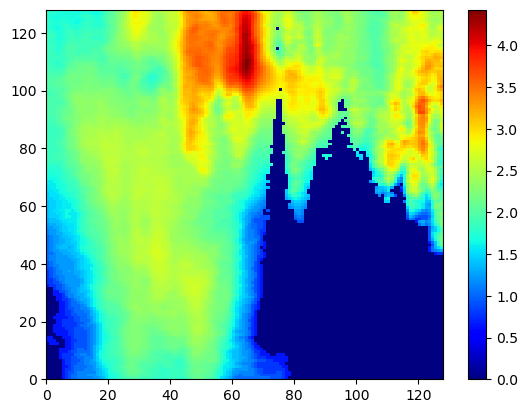

In [42]:
plt.pcolormesh(data[0, ..., 0], cmap=plt.cm.jet)
plt.colorbar()

In [ ]:
for lead in LEADs:
    # Main section
    for i_dt, dt in enumerate(date_list[:1]):
    
        filename_gfs = datetime.strftime(dt, 
        '/glade/campaign/collections/rda/data/ds084.1/%Y/%Y%m%d/gfs.0p25.%Y%m%d%H.f{:03d}.grib2'.format(lead))
        
        dt0 = dt + timedelta(hours=lead-2)
        dt1 = dt + timedelta(hours=lead-1)
        dt2 = dt + timedelta(hours=lead)
    
        dt_str0 = datetime.strftime(dt0, '%Y%m%d-%H%M%S')
        dt_str1 = datetime.strftime(dt1, '%Y%m%d-%H%M%S')
        dt_str2 = datetime.strftime(dt2, '%Y%m%d-%H%M%S')
        
        name0 = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str0)
        name1 = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str1)
        name2 = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str2)
        
        filename0 = MRMS_dir + name0
        filename1 = MRMS_dir + name1
        filename2 = MRMS_dir + name2
    
        flag_mrms0 = os.path.isfile(filename0)
        flag_mrms1 = os.path.isfile(filename1)
        flag_mrms2 = os.path.isfile(filename2)
        flag_gfs = os.path.isfile(filename_gfs)
        
        if np.logical_and(np.logical_and(np.logical_and(flag_mrms0, flag_mrms1), flag_mrms2), flag_gfs):
            with pygrib.open(filename0) as grbio:
                MRMS = grbio[1].values
                
            with pygrib.open(filename0) as grbio:
                MRMS += grbio[1].values
                
            with pygrib.open(filename0) as grbio:
                MRMS += grbio[1].values
                
            # flip --> lower latitude at the bottom
            MRMS = np.flipud(MRMS)
            
            print(filename_gfs)
            
            with pygrib.open(filename_gfs) as grbio:
                T = grbio[314+1].values #
                U = grbio[319+1].values
                RH = grbio[315+1].values
                APCP = grbio[450+1].values
                CAPE = grbio[473+1].values
                PWAT = grbio[475+1].values
            
            T_NA = T[:-360, 720:]
            T_NA = np.flipud(np.concatenate((T_NA, T[:-360, 0][:, None]), axis=1))
            
            U_NA = U[:-360, 720:]
            U_NA = np.flipud(np.concatenate((U_NA, U[:-360, 0][:, None]), axis=1))
            
            RH_NA = RH[:-360, 720:]
            RH_NA = np.flipud(np.concatenate((RH_NA, RH[:-360, 0][:, None]), axis=1))
            
            APCP_NA = APCP[:-360, 720:]
            APCP_NA = np.flipud(np.concatenate((APCP_NA, APCP[:-360, 0][:, None]), axis=1))
            
            CAPE_NA = CAPE[:-360, 720:]
            CAPE_NA = np.flipud(np.concatenate((CAPE_NA, CAPE[:-360, 0][:, None]), axis=1))
            
            PWAT_NA = PWAT[:-360, 720:]
            PWAT_NA = np.flipud(np.concatenate((PWAT_NA, PWAT[:-360, 0][:, None]), axis=1))
            
            for i_mrms in range(0, x_mrms-size_mrms+gap, gap):
                for j_mrms in range(0, y_mrms-size_mrms+gap, gap):
                    
                    i0 = i_mrms; i1 = i0 + size_mrms
                    j0 = j_mrms; j1 = j0 + size_mrms
    
                    if (np.sum(RQI[i0:i1, j0:j1]) < 0.75) == 0:
                    
                        patch_ = MRMS[i0:i1, j0:j1]
                        land_mask_ = land_mask_MRMS[i0:i1, j0:j1]
    
                        r_rain = np.sum(patch_ > thres_dry)/N_grids
                        
                        flag_size = patch_.shape == (size_mrms, size_mrms)
                        flag_rain_cover = r_rain >= thres_rain_cover
                        flag_land_cover = (np.sum(land_mask_)/N_grids) >= thres_land_cover
                        flag_extreme = np.logical_and(np.max(patch_) >= thres_extreme, r_rain >= thres_extreme_cover)
        
                        flag_pass1 = np.logical_and(flag_rain_cover, flag_land_cover)
                        flag_pass2 = np.logical_and(flag_extreme, flag_land_cover)
                        flag_pass_final = np.logical_or(flag_pass1, flag_pass2)
        
                        if flag_size and flag_pass_final:
                            
                            i_era = indx[i0:i1, j0:j1]
                            j_era = indy[i0:i1, j0:j1]
    
                            i_min = np.int(np.min(i_era))
                            i_max = np.int(np.max(i_era))
                            j_min = np.int(np.min(j_era))
                            j_max = np.int(np.max(j_era))
                            
                            data_t = T_NA[i_min:i_max+1, j_min:j_max+1]
                            data_u = U_NA[i_min:i_max+1, j_min:j_max+1]
                            data_r = RH_NA[i_min:i_max+1, j_min:j_max+1]
                            data_pwat = PWAT_NA[i_min:i_max+1, j_min:j_max+1]
                            data_cape = CAPE_NA[i_min:i_max+1, j_min:j_max+1]
                            data_apcp = APCP_NA[i_min:i_max+1, j_min:j_max+1]
                            
                            shape_lr = data_t.shape
                            if shape_lr[0] == 6:
                                x_ = x_lr6
                            else:
                                x_ = x_lr7
                            
                            if shape_lr[1] == 6:
                                y_ = x_lr6
                            else:
                                y_ = x_lr7
    
    
                            elev_ = elev_MRMS[i0:i1, j0:j1]
                            data[0, ..., 8] = elev_
                            
                            interp_obj_t = interp2d(y_, x_, data_t, kind='linear')
                            data[0, ..., 7] = interp_obj_t(x_hr128, x_hr128)
    
                            interp_obj_u = interp2d(y_, x_, data_u, kind='linear')
                            data[0, ..., 6] = interp_obj_u(x_hr128, x_hr128)
    
                            interp_obj_r = interp2d(y_, x_, data_r, kind='linear')
                            data[0, ..., 5] = interp_obj_r(x_hr128, x_hr128)
    
                            interp_obj_pwat = interp2d(y_, x_, data_pwat, kind='linear')
                            data[0, ..., 4] = interp_obj_pwat(x_hr128, x_hr128)
    
                            interp_obj_cape = interp2d(y_, x_, data_cape, kind='linear')
                            data[0, ..., 3] = interp_obj_cape(x_hr128, x_hr128)
    
                            interp_obj_apcp = interp2d(y_, x_, data_apcp, kind='linear')
                            data[0, ..., 2] = interp_obj_apcp(x_hr128, x_hr128)
    
                            data[0, ..., 0] = patch_
                            
                            hr_to_lr = interp2d(x_hr, x_hr, data[0, ..., 0], kind='linear')
                            data_lr = hr_to_lr(y_, x_)
                            lr_to_hr = interp2d(y_, x_, data_lr, kind='linear')
                            data_hr = lr_to_hr(x_hr, x_hr)
    
                            data[0, ..., 1] = data_hr
                            
                            data[0, ..., 0] = norm_precip(data[0, ..., 0])
                            data[0, ..., 1] = norm_precip(data[0, ..., 1])
                            data[0, ..., 2] = norm_precip(data[0, ..., 2])
                            data[0, ..., 3] = norm_cape(data[0, ..., 3])
                            data[0, ..., 4] = norm_pwat(data[0, ..., 4])
                            data[0, ..., 5] = norm_rh(data[0, ..., 5])
                            data[0, ..., 6] = norm_u(data[0, ..., 6])
                            data[0, ..., 7] = norm_t(data[0, ..., 7])
    
                            flag_save = True
                            for i_test in range(5):
                                temp = np.abs(data[0, ..., 3+i_test])
                                if np.sum(temp > 1e-6) == 0:
                                    flag_save = False
                                    
                            if flag_save:
                                name_ = BATCH_dir+batch_file_name.format(year, lead, i_dt, i_mrms, j_mrms)
                                print(name_)
                                np.save(name_, data)

/glade/campaign/collections/rda/data/ds084.1/2021/20210101/gfs.0p25.2021010100.f003.grib2
/glade/campaign/cisl/aiml/ksha/BATCH_GFS/GFS_y2021_lead03_dt0000_i0704_j3712.npy
/glade/campaign/cisl/aiml/ksha/BATCH_GFS/GFS_y2021_lead03_dt0000_i0704_j3776.npy


In [45]:
data = np.load('/glade/campaign/cisl/aiml/ksha/BATCH_GFS/GFS_y2021_lead03_dt0000_i0664_j3704.npy')

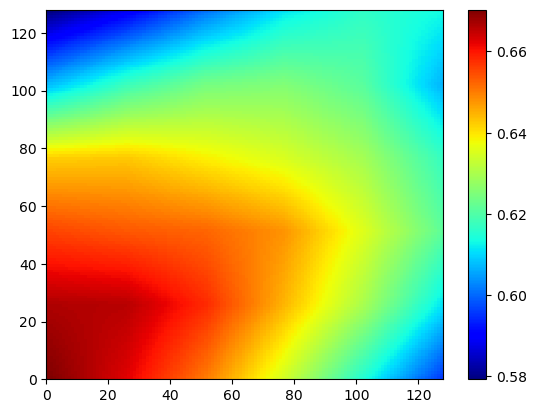

In [52]:
plt.pcolormesh(data[0, ..., 6], cmap=plt.cm.jet)
plt.colorbar()